## File sau thực hiện để code python



In [10]:
# Import library python in here 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import pandas as pd

In [19]:


# Step 1: Read the data from the file
data_file = r'C:\Users\luan1\OneDrive\Desktop\DATN_20232\Data\WLS.txt'
try:
    data = np.loadtxt(data_file, delimiter='\t', skiprows=1)
except Exception as e:
    print(f"Error reading data file: {e}")
    raise

# Extracting measurements (zs)
zs = data[:, :3]

# For simplicity, assume control inputs (us) are zero (no control input)
us = np.zeros_like(zs)

# Step 2: Estimate covariances
# Use small values for covariances since the data seems to be stable
cov_zs = np.full((zs.shape[0], 3, 3), 1e-2 * np.eye(3))
cov_us = np.full((us.shape[0], 3, 3), 1e-2 * np.eye(3))

# Step 3: Define the Kalman filter function
def Kalman_filter_debug(zs, us, cov_zs, cov_us, phone=None):
    sigma_mahalanobis = 30.0  # Mahalanobis distance for rejecting innovation

    n, dim_x = zs.shape
    F = np.eye(3)  # Transition matrix
    H = np.eye(3)  # Measurement function

    x = zs[0, :3].T  # State
    P = 5.0**2 * np.eye(3)  # State covariance
    I = np.eye(dim_x)

    x_kf = np.zeros([n, dim_x])
    P_kf = np.zeros([n, dim_x, dim_x])

    print("Initial state x:", x)
    print("Initial covariance P:", P)

    for i, (u, z) in enumerate(zip(us, zs)):
        print(f"\nStep {i+1}:")
        
        if i == 0:
            x_kf[i] = x.T
            P_kf[i] = P
            print("Initial step, setting initial values.")
            continue

        # Prediction step
        Q = cov_us[i]
        x = F @ x + u.T
        P = (F @ P) @ F.T + Q
        print("Predicted state x:", x)
        print("Predicted covariance P:", P)

        # Check outliers for observation
        d = distance.mahalanobis(z, H @ x, np.linalg.inv(P))
        print("Mahalanobis distance d:", d)

        # Update step
        if d < sigma_mahalanobis:
            R = cov_zs[i]
            y = z.T - H @ x
            S = (H @ P) @ H.T + R
            K = (P @ H.T) @ np.linalg.inv(S)
            x = x + K @ y
            P = (I - (K @ H)) @ P
            print("Updated state x after measurement:", x)
            print("Updated covariance P after measurement:", P)
        else:
            # If observation update is not available, increase covariance
            P += 10**2 * Q
            print("Observation rejected, increased covariance P:", P)

        x_kf[i] = x.T
        P_kf[i] = P

    return x_kf, P_kf

# Step 4: Apply the Kalman filter
x_kf, P_kf = Kalman_filter(zs, us, cov_zs, cov_us)

# Step 5: Output the results
results_df = pd.DataFrame(x_kf, columns=['Filtered_X', 'Filtered_Y', 'Filtered_Z'])
output_file = r'C:\Users\luan1\OneDrive\Desktop\DATN_20232\Data\KalmanFilter_test.csv'
try:
    results_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")
except Exception as e:
    print(f"Error saving results to CSV: {e}")
    raise

print(results_df.head())

Results saved to C:\Users\luan1\OneDrive\Desktop\DATN_20232\Data\KalmanFilter_test.csv
    Filtered_X  Filtered_Y   Filtered_Z
0 -2677823.217 -4321159.76  3839089.668
1 -2677823.217 -4321159.76  3839089.668
2 -2677823.217 -4321159.76  3839089.668
3 -2677823.217 -4321159.76  3839089.668
4 -2677823.217 -4321159.76  3839089.668


## Display result after and before Kalman Filter in 2 chart 

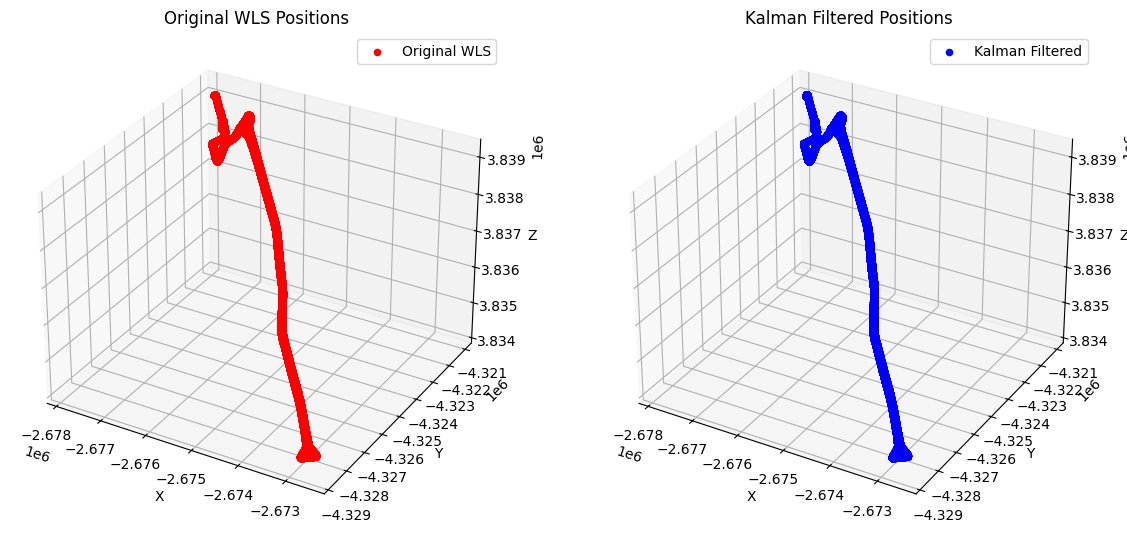

In [11]:
# Plotting the results
fig = plt.figure(figsize=(14, 7))

# Plot original WLS positions
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(zs[:, 0], zs[:, 1], zs[:, 2], c='r', marker='o', label='Original WLS')
ax1.set_title('Original WLS Positions')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()

# Plot filtered positions
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(x_kf[:, 0], x_kf[:, 1], x_kf[:, 2], c='b', marker='o', label='Kalman Filtered')
ax2.set_title('Kalman Filtered Positions')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.legend()

plt.show()

## Code here to display together result in chart

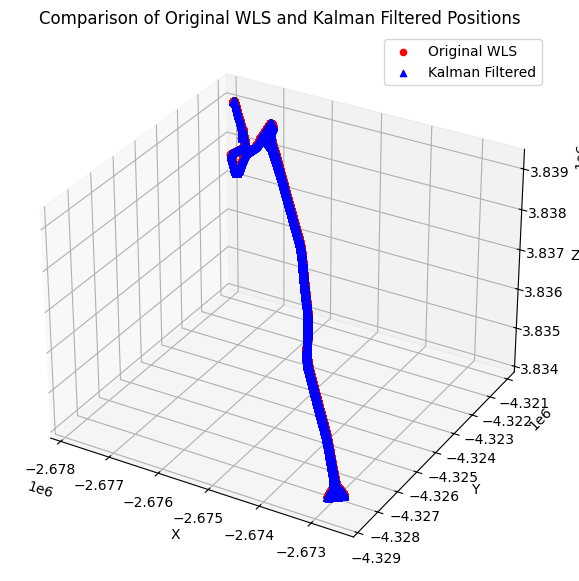

In [12]:
# Plotting the results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot original WLS positions
ax.scatter(zs[:, 0], zs[:, 1], zs[:, 2], c='r', marker='o', label='Original WLS')

# Plot filtered positions
ax.scatter(x_kf[:, 0], x_kf[:, 1], x_kf[:, 2], c='b', marker='^', label='Kalman Filtered')

ax.set_title('Comparison of Original WLS and Kalman Filtered Positions')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()